<a href="https://colab.research.google.com/github/naga-dheeraj-p/Assignments/blob/main/Crypto%2Bsentiment%2Bdone_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data=pd.read_csv('/content/gdrive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv.zip')
data['Timestamp'] = pd.to_datetime(data.iloc[:, 0], unit='s')
data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [4]:
data.drop(columns=['Volume_(Currency)','Weighted_Price'],inplace=True)
data['returns'] = ((data['Close'] / data['Open']) - 1) * 100 #calculating returns for each hour
data.set_index('Timestamp', inplace=True)
data.tail()

,Open,High,Low,Close,Volume_(BTC),returns
Timestamp,,,,,,
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,-0.048217
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,0.003135
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,0.051812
2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,0.031340
2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,0.017748


In [5]:
hourly_data = data.resample('H').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Volume_(BTC)': 'sum','returns': 'mean'})  # Assuming 'returns' is a column representing minute-level returns
daily_data=hourly_data.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume_(BTC)': 'sum', 'returns': 'mean'})
hourly_data.reset_index(inplace=True)
hourly_data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),returns
81061,2021-03-30 20:00:00,59118.91,59135.00,58402.82,58669.04,118.576288,-0.013386
81062,2021-03-30 21:00:00,58644.04,58872.27,58570.57,58759.04,57.605048,0.008879
81063,2021-03-30 22:00:00,58758.44,58941.34,58642.58,58711.15,68.019168,-0.000902
81064,2021-03-30 23:00:00,58699.43,58770.38,58567.11,58760.59,78.329260,0.001545
81065,2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,0.017748


In [6]:
rolling_returns = hourly_data['returns'].rolling(window=30).mean() #calculating mean
std_dev = hourly_data['returns'].rolling(window=30).std() #calculating std deviation

daily_rolling_returns=daily_data['returns'].rolling(window=30).mean()
daily_std_dev = daily_data['returns'].rolling(window=30).std()

In [7]:
k=1.75 # Selected this due to lesser number of false signals
#___________________________________________________________


hourly_data['overreaction'] = np.where(hourly_data['returns'] > rolling_returns + k * std_dev, 1,
                                    np.where(hourly_data['returns'] < rolling_returns - k * std_dev, -1, 0))

daily_data['overreaction'] = np.where(daily_data['returns'] > daily_rolling_returns + k * daily_std_dev, 1,
                                    np.where(daily_data['returns'] < daily_rolling_returns - k * daily_std_dev, -1, 0))

In [8]:
hourly_data.head()
daily_data.head()

,Open,High,Low,Close,Volume_(BTC),returns,overreaction
Timestamp,,,,,,,
2011-12-31,4.39,4.58,4.39,4.58,95.317878,0.388889,0
2012-01-01,4.58,5.00,4.58,5.00,21.602000,0.000000,0
2012-01-02,5.00,5.00,5.00,5.00,19.048000,0.000000,0
2012-01-03,5.32,5.32,5.14,5.29,88.037281,0.000000,0
2012-01-04,4.93,5.57,4.93,5.57,107.233260,0.651827,0


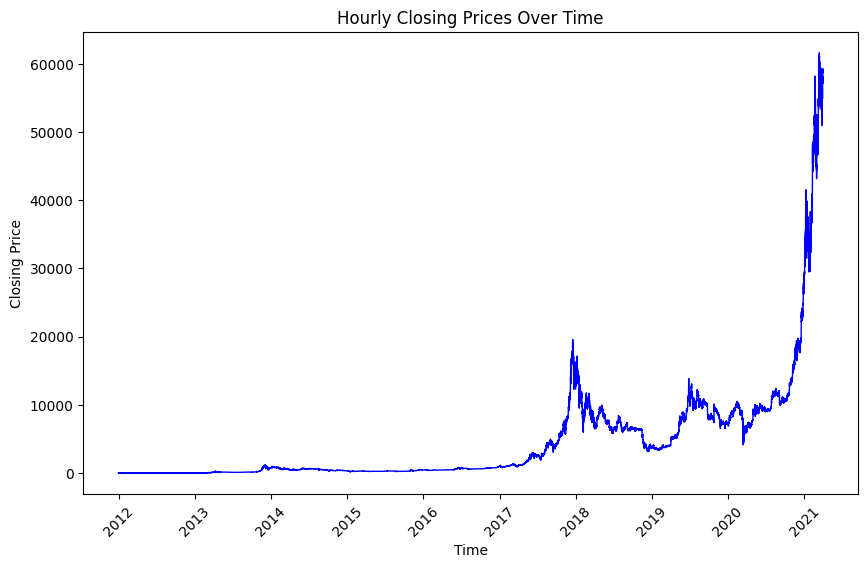

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_data['Timestamp'], hourly_data['Close'], color='blue', linewidth=1) # Plot the closing prices
plt.title('Hourly Closing Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)  # Rotating x-axis labels
plt.show()

In [10]:
pip install imbalanced-learn

In [11]:
value_counts = hourly_data['overreaction'].value_counts()
print(value_counts)
daily_value_counts=daily_data['overreaction'].value_counts()
print(daily_value_counts)

overreaction
 0    72353
-1     4478
 1     4235
Name: count, dtype: int64
overreaction
 0    2953
-1     224
 1     202
Name: count, dtype: int64


In [12]:
hourly_data['Timestamp'] = pd.to_datetime(hourly_data['Timestamp'])
hourly_data_2016_onwards = hourly_data[hourly_data['Timestamp'].dt.year >= 2016]
hourly_data_2016_onwards.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,overreaction
35081,2016-01-01 00:00:00,430.89,432.58,429.82,431.02,41.320972,-0.024261,-1
35082,2016-01-01 01:00:00,431.51,432.01,429.08,430.01,31.212239,-0.001497,0
35083,2016-01-01 02:00:00,430.00,431.69,430.00,430.57,12.246236,-0.001942,0
35084,2016-01-01 03:00:00,430.50,433.37,430.03,433.37,74.984254,0.024811,0
35085,2016-01-01 04:00:00,433.34,435.72,432.55,435.11,870.803435,-0.006614,0


In [13]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e6e51e9ae573cfb31aaee588303a91236b5f791992fca0d00538d4ccf0ac7bd7
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [14]:
from ta import add_all_ta_features
hourly_data_2016_onwards = hourly_data_2016_onwards.copy()

# Calculating MovingAvg, RSI, MACD, etc.
training_data = add_all_ta_features(hourly_data_2016_onwards, open='Open', high='High', low='Low', close='Close', volume='Volume_(BTC)', fillna=True)

training_data = training_data[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'returns','trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow','overreaction']]
training_data.head()

/usr/local/lib/python3.10/dist-packages/ta/volume.py:290: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self._vpt = (self._close.pct_change() * self._volume).cumsum()
/usr/local/lib/python3.10/dist-packages/ta/volume.py:327: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_change = self._close.pct_change()


,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,overreaction
35081,2016-01-01 00:00:00,430.89,432.58,429.82,431.02,41.320972,-0.024261,0.000000,0.000000,0.000000,431.020000,431.020000,431.020000,431.020000,-1
35082,2016-01-01 01:00:00,431.51,432.01,429.08,430.01,31.212239,-0.001497,-0.080570,-0.016114,-0.064456,430.515000,430.515000,430.864615,430.945185,0
35083,2016-01-01 02:00:00,430.00,431.69,430.00,430.57,12.246236,-0.001942,-0.098104,-0.032512,-0.065592,430.533333,430.533333,430.819290,430.917394,0
35084,2016-01-01 03:00:00,430.50,433.37,430.03,433.37,74.984254,0.024811,0.112639,-0.003482,0.116120,431.242500,431.242500,431.211707,431.099068,0
35085,2016-01-01 04:00:00,433.34,435.72,432.55,435.11,870.803435,-0.006614,0.415270,0.080269,0.335001,432.016000,432.016000,431.811444,431.396174,0


In [15]:
nan_values_columnwise = training_data.isna().sum()
nan_values_columnwise

,0
Timestamp,0
Open,4
High,4
Low,4
Close,4
Volume_(BTC),0
returns,4
trend_macd,0
trend_macd_signal,0
trend_macd_diff,0


In [16]:
training_data['overreaction'] = training_data['overreaction'].astype(float)

columns = list(training_data.columns)
columns.remove('overreaction')
columns.append('overreaction')

training_data = training_data.reindex(columns=columns)
training_data.head()
#print(training_data.shape)

<ipython-input-16-e4c08a3659b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['overreaction'] = training_data['overreaction'].astype(float)


,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,overreaction
35081,2016-01-01 00:00:00,430.89,432.58,429.82,431.02,41.320972,-0.024261,0.000000,0.000000,0.000000,431.020000,431.020000,431.020000,431.020000,-1.0
35082,2016-01-01 01:00:00,431.51,432.01,429.08,430.01,31.212239,-0.001497,-0.080570,-0.016114,-0.064456,430.515000,430.515000,430.864615,430.945185,0.0
35083,2016-01-01 02:00:00,430.00,431.69,430.00,430.57,12.246236,-0.001942,-0.098104,-0.032512,-0.065592,430.533333,430.533333,430.819290,430.917394,0.0
35084,2016-01-01 03:00:00,430.50,433.37,430.03,433.37,74.984254,0.024811,0.112639,-0.003482,0.116120,431.242500,431.242500,431.211707,431.099068,0.0
35085,2016-01-01 04:00:00,433.34,435.72,432.55,435.11,870.803435,-0.006614,0.415270,0.080269,0.335001,432.016000,432.016000,431.811444,431.396174,0.0


OUTLIER REMOVAL

In [17]:
#print(training_data.count())
print('')
columns_to_handle_outliers=['Open','High',	'Low',	'Close',	'Volume_(BTC)',	'returns']
for i in columns_to_handle_outliers:
    Q1 =  training_data[i].quantile(0.25)
    Q3 =  training_data[i].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (training_data[i] < lower_bound) | (training_data[i] > upper_bound)
    training_data.loc[outliers, i] = None

processed_data= training_data.dropna()
#print(processed_data.count())
processed_data.head()
processed_data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,overreaction
78566,2020-12-16 21:00:00,20830.11,21320.61,20740.55,21215.49,844.146644,0.029919,412.926249,312.066449,100.859799,20503.992500,19927.133462,20539.161271,20126.235023,1.0
78567,2020-12-16 22:00:00,21206.50,21464.97,21203.77,21393.45,667.725259,-0.001532,450.487508,339.750661,110.736847,20636.969167,20000.024615,20670.590307,20220.102799,0.0
78568,2020-12-16 23:00:00,21393.55,21576.76,21218.58,21365.70,639.172448,-0.017849,472.568409,366.314211,106.254198,20771.340000,20074.542692,20777.530259,20304.961851,-1.0
78569,2020-12-17 00:00:00,21358.96,21423.13,21244.04,21423.13,409.553895,0.007135,489.064175,390.864203,98.199972,20908.550000,20149.793846,20876.853296,20387.789121,0.0
78570,2020-12-17 01:00:00,21416.95,21880.00,21416.95,21738.47,680.886171,0.014474,521.570156,417.005394,104.564762,21024.955833,20238.393846,21009.409712,20487.839557,0.0


KNN

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Slicing
x = processed_data.iloc[:, 1:-1].values
y = processed_data.iloc[:, -1].values

# Removing the missing values
clean_indices = ~np.isnan(x).any(axis=1)
x_cleaned = x[clean_indices]
y_cleaned = y[clean_indices]

# StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_cleaned)

# Performing Principal component analysis

pca = PCA(0.85)
x_pca = pca.fit_transform(x_scaled)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_cleaned, test_size=0.3, random_state=40, stratify=y_cleaned)

# KNN MODEL
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
#print(np.unique(y_cleaned))
print("Accuracy:", round(accuracy * 100, 2), "%")

Accuracy: 91.66 %


In [19]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (Weighted):", round(f1,3))

F1 Score (Weighted): 0.9


# Testing Data

In [20]:
'''!pip install ccxt'''

'!pip install ccxt'

In [21]:
'''pip install python-binance'''

'pip install python-binance'

In [22]:
testing_data=pd.read_csv('/content/gdrive/MyDrive/testingdata_BTC.zip')
testing_data['Date'] = pd.to_datetime(testing_data['Date'], errors='coerce') # Handling errors in datetime

filtered_data = testing_data[(testing_data['Date'].dt.year == 2022) | (testing_data['Date'].dt.year == 2023)].copy()

filtered_data.drop(columns=['Symbol','tradecount','Volume USDT'], inplace=True)
filtered_data['returns'] = ((filtered_data['Close'] / filtered_data['Open']) - 1) * 100
reversed_data = filtered_data.iloc[::-1]


reversed_data.head()
reversed_data.tail()

,Date,Open,High,Low,Close,Volume BTC,returns
4,2023-10-19 19:00:00,28646.98,28765.76,28645.00,28750.75,1039.20935,0.362237
3,2023-10-19 20:00:00,28750.75,28882.07,28684.80,28715.38,1737.14711,-0.123023
2,2023-10-19 21:00:00,28715.39,28739.73,28604.09,28604.09,1118.51697,-0.387597
1,2023-10-19 22:00:00,28604.09,28704.99,28598.60,28649.65,767.85518,0.159278
0,2023-10-19 23:00:00,28649.64,28717.82,28630.19,28713.71,613.28448,0.223633


In [23]:
# Preprocess the new data
reversed_data_copy = reversed_data.copy()

training_data = add_all_ta_features(reversed_data_copy, open='Open', high='High', low='Low', close='Close', volume='Volume BTC', fillna=True)

training_data = training_data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume BTC', 'returns','trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']]

new_x = training_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume BTC', 'returns', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']].values


clean_indices_new = ~np.isnan(new_x).any(axis=1)
new_x_cleaned = new_x[clean_indices_new]

new_x_scaled = scaler.transform(new_x_cleaned)
new_x_pca = pca.transform(new_x_scaled)
new_y_pred = knn.predict(new_x_pca)

print("Predicted overrelation for new data:", new_y_pred)


Predicted overrelation for new data: [1. 1. 1. ... 0. 1. 1.]


In [24]:
unique_values, counts = np.unique(new_y_pred, return_counts=True)
print(dict(zip(unique_values, counts)))

{-1.0: 562, 0.0: 12271, 1.0: 2933}


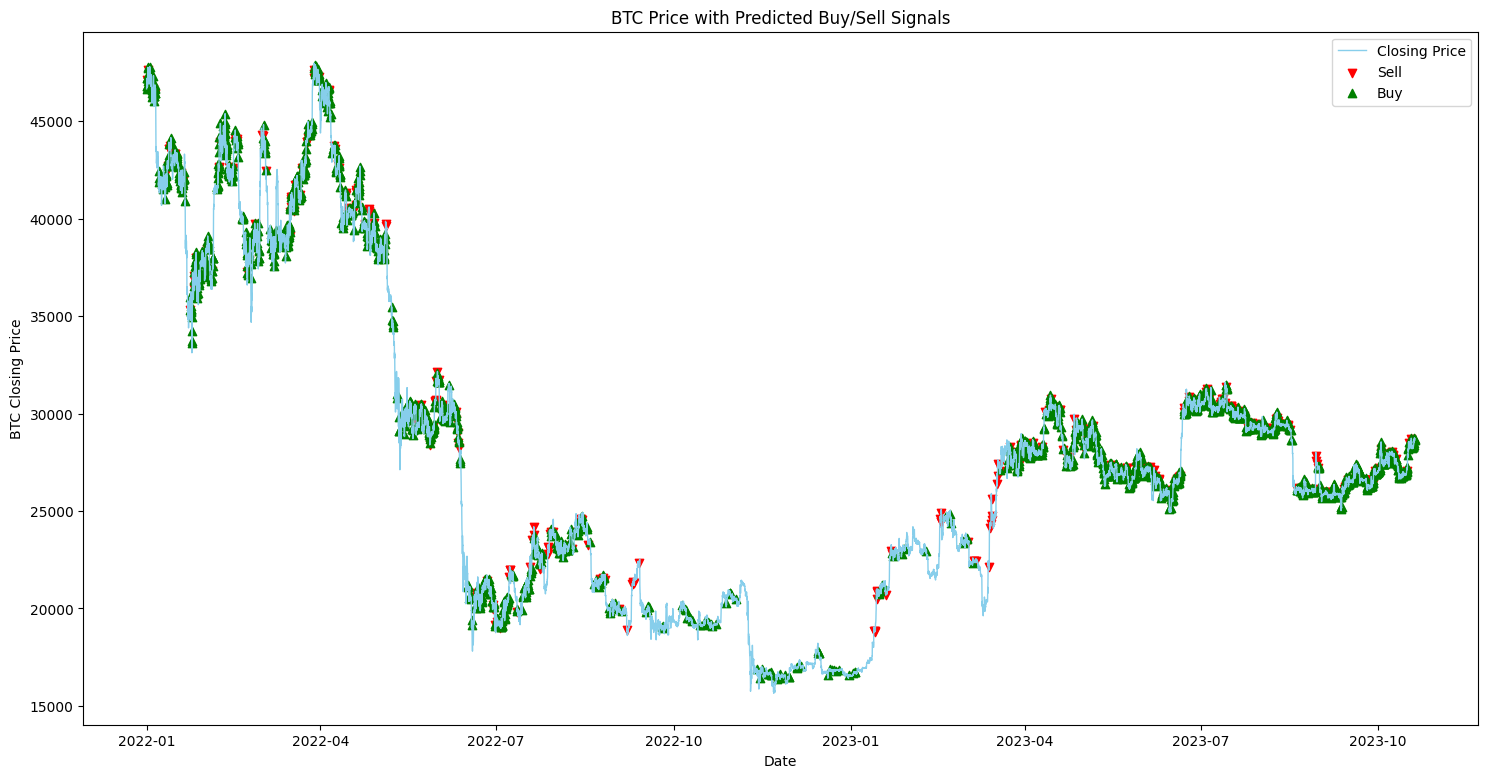

In [25]:
import matplotlib.pyplot as plt

timestamps=reversed_data['Date']
closing_prices=reversed_data['Close']

predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Close': closing_prices})

predicted_df['Predicted Overreaction'] = new_y_pred

plt.figure(figsize=(18, 9))
plt.plot(predicted_df['Timestamp'], predicted_df['Close'], color='skyblue', label='Closing Price',linewidth=1)

# Plot the predicted overreaction values with different markers or colors
sell_points = predicted_df[predicted_df['Predicted Overreaction'] == -1.0]
buy_points = predicted_df[predicted_df['Predicted Overreaction'] == 1.0]
plt.scatter(sell_points['Timestamp'], sell_points['Close'], color='red', label='Sell', marker='v')
plt.scatter(buy_points['Timestamp'], buy_points['Close'], color='green', label='Buy', marker='^')

plt.xlabel('Date')
plt.ylabel('BTC Closing Price')
plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.legend()
plt.show()

CALCULATING PROFIT PERCENTAGE

In [26]:
import pandas as pd


reversed_data = reversed_data.copy()  # Making a copy of the DataFrame
reversed_data['Predicted Overreaction'] = new_y_pred

grouped_data = reversed_data.groupby(reversed_data['Date'].dt.date) # Grouping date to calculate the returns for the entire day

total_returns = {}

for date, group in grouped_data:
    day_data = group[group['Date'].dt.date == date]
    buy_signals = (day_data['Predicted Overreaction'] == 1.0)
    sell_signals = (day_data['Predicted Overreaction'] == -1.0)

    buy_returns = day_data.loc[buy_signals, 'returns']
    sell_returns = day_data.loc[sell_signals, 'returns']

    buy_profit_loss = (buy_returns / 100)  # Converting percentage to decimal
    sell_profit_loss = -(sell_returns / 100)

    total_return = buy_profit_loss.sum() + sell_profit_loss.sum()
    total_returns[date] = total_return

total_returns_df = pd.DataFrame.from_dict(total_returns, orient='index', columns=['Total Return'])
non_zero_returns_df = total_returns_df[total_returns_df['Total Return'] != 0]

non_zero_returns_df.head()

,Total Return
2022-01-01,0.062178
2022-01-02,0.032563
2022-01-03,0.030142
2022-01-04,0.048334
2022-01-05,0.040153


In [27]:
initial_investment = 10000

non_zero_returns_df = non_zero_returns_df.copy()  # Make a copy of the DataFrame
non_zero_returns_df['Final Value if invested'] = initial_investment * (1 + non_zero_returns_df['Total Return'])
non_zero_returns_df.head()

,Total Return,Final Value if invested
2022-01-01,0.062178,10621.783153
2022-01-02,0.032563,10325.628064
2022-01-03,0.030142,10301.415808
2022-01-04,0.048334,10483.343733
2022-01-05,0.040153,10401.532784


In [28]:
total_return_sum = non_zero_returns_df['Total Return'].sum()

total_returns = total_return_sum * initial_investment
print("Total Returns:", round(total_returns,2),'$')

ROI_percentage = (total_returns / initial_investment) * 100
print("ROI (Return on Investment) percentage:", round(ROI_percentage,2), "%")

Total Returns: 116203.07 $
ROI (Return on Investment) percentage: 1162.03 %


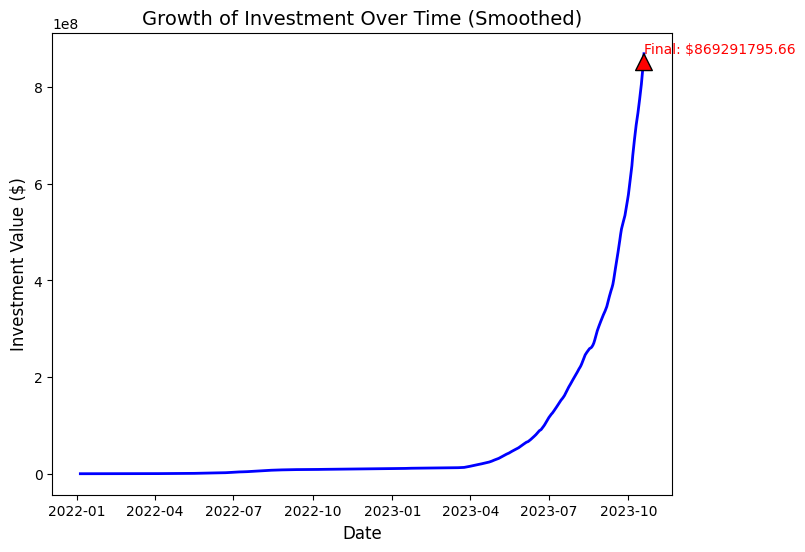

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'non_zero_returns_df' and 'initial_investment' are defined as before

# Calculate the cumulative investment value
non_zero_returns_df['Investment Value'] = initial_investment * (1 + non_zero_returns_df['Total Return']).cumprod()

# Apply a rolling window to smooth the curve (e.g., 5 days rolling window)
non_zero_returns_df['Smoothed Investment Value'] = non_zero_returns_df['Investment Value'].rolling(window=5).mean()

# Plot the smoothed investment value
plt.figure(figsize=(8, 6))
plt.plot(non_zero_returns_df.index, non_zero_returns_df['Smoothed Investment Value'], color='blue', linewidth=2)

# Adding title and labels
plt.title("Growth of Investment Over Time (Smoothed)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Investment Value ($)", fontsize=12)


# Mark the initial value
initial_value = non_zero_returns_df['Smoothed Investment Value'].iloc[0]
plt.annotate(f'Initial: ${initial_value:.2f}',
             xy=(non_zero_returns_df.index[0], initial_value),
             xytext=(non_zero_returns_df.index[0], initial_value + 100),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10, color='green')

# Mark the final value
final_value = non_zero_returns_df['Smoothed Investment Value'].iloc[-1]
plt.annotate(f'Final: ${final_value:.2f}',
             xy=(non_zero_returns_df.index[-1], final_value),
             xytext=(non_zero_returns_df.index[-1], final_value + 100),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=10, color='red')

# Show the plot
plt.show()


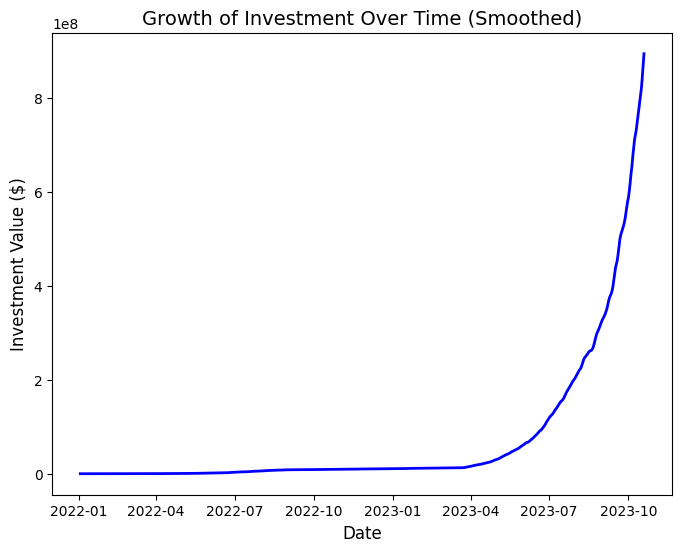

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'non_zero_returns_df' and 'initial_investment' are defined as before

# Calculate the cumulative investment value
non_zero_returns_df['Investment Value'] = initial_investment * (1 + non_zero_returns_df['Total Return']).cumprod()

# Apply a rolling window to smooth the curve (e.g., 5 days rolling window)
non_zero_returns_df['Smoothed Investment Value'] = non_zero_returns_df['Investment Value'].rolling(window=3).mean()

# Plot the smoothed investment value
plt.figure(figsize=(8, 6))
plt.plot(non_zero_returns_df.index, non_zero_returns_df['Smoothed Investment Value'], color='blue', linewidth=2)

# Adding title and labels
plt.title("Growth of Investment Over Time (Smoothed)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Investment Value ($)", fontsize=12)


# Show the plot
plt.show()


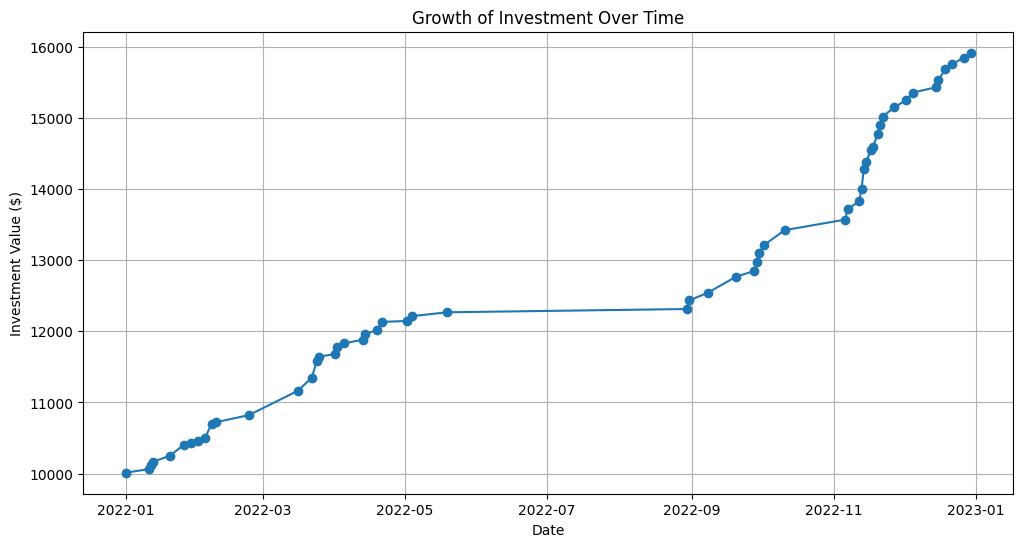

CAGR: 26.1531%


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'reversed_data' is your DataFrame and other steps are already done.

# Group data by date to calculate the total return for each day
grouped_data = reversed_data.groupby(reversed_data['Date'].dt.date)

total_returns = {}

for date, group in grouped_data:
    day_data = group[group['Date'].dt.date == date]
    buy_signals = (day_data['Predicted Overreaction'] == 1.0)
    sell_signals = (day_data['Predicted Overreaction'] == -1.0)

    buy_returns = day_data.loc[buy_signals, 'returns']
    sell_returns = day_data.loc[sell_signals, 'returns']

    buy_profit_loss = (buy_returns / 100)  # Converting percentage to decimal
    sell_profit_loss = -(sell_returns / 100)

    total_return = buy_profit_loss.sum() + sell_profit_loss.sum()
    total_returns[date] = total_return

# Create DataFrame from total returns dictionary
total_returns_df = pd.DataFrame.from_dict(total_returns, orient='index', columns=['Total Return'])

# Filter out days with zero return
non_zero_returns_df = total_returns_df[total_returns_df['Total Return'] != 0]

# Calculate final investment value over time
initial_investment = 10000
non_zero_returns_df = non_zero_returns_df.copy()  # Make a copy of the DataFrame
non_zero_returns_df['Investment Value'] = initial_investment * (1 + non_zero_returns_df['Total Return']).cumprod()

# Plotting the growth of the investment amount
plt.figure(figsize=(12, 6))
plt.plot(non_zero_returns_df.index, non_zero_returns_df['Investment Value'], marker='o')
plt.title('Growth of Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')
plt.grid(True)
plt.show()

# Calculate CAGR
beginning_value = initial_investment
ending_value = non_zero_returns_df['Investment Value'].iloc[-1]
#num_years = (non_zero_returns_df.index[-1] - non_zero_returns_df.index[0]).days / 365.25
num_years=2
CAGR = (ending_value / beginning_value) ** (1 / num_years) - 1
print(f"CAGR: {CAGR:.4%}")


Heuristic-Based Crypto Trading System | Python, Pandas, Numpy, Matplotlib, Machine Learning (2023)
• Developed machine learning models to predict Momentum in cryptocurrency, using Python for data exploration and feature extraction. Enhanced a heuristic overreaction detection method by incorporating statistical thresholds based
on daily returns and standard deviations, and trained classifiers to reduce false signals using technical indicators.
• Integrated advanced sentiment analysis of tweets, calculated sentiment scores, and incorporated them as key
features in model training, significantly enhancing the prediction accuracy and robustness of the trading models.
• Implemented and evaluated various machine learning models, including K-Nearest Neighbors (KNN), Random
Forest, and Logistic Regression, achieving the best performance with the KNN model (F1 score: 0.925) and attaining a remarkable two-year ROI of 46.75%.”

I WANT TO POST THIS PROJECT ON LINKEDIN
AND THE CODE IS

rolling_returns = hourly_data['returns'].rolling(window=30).mean() #calculating mean
std_dev = hourly_data['returns'].rolling(window=30).std() #calculating std deviation

daily_rolling_returns=daily_data['returns'].rolling(window=30).mean()
daily_std_dev = daily_data['returns'].rolling(window=30).std()
     

k=2 # Selected this due to lesser number of false signals
hourly_data['overreaction'] = np.where(hourly_data['returns'] > rolling_returns + k * std_dev, 1,
                                    np.where(hourly_data['returns'] < rolling_returns - k * std_dev, -1, 0))

daily_data['overreaction'] = np.where(daily_data['returns'] > daily_rolling_returns + k * daily_std_dev, 1,
                                    np.where(daily_data['returns'] < daily_rolling_returns - k * daily_std_dev, -1, 0))
     from ta import add_all_ta_features
hourly_data_2016_onwards = hourly_data_2016_onwards.copy()

# Calculating MovingAvg, RSI, MACD, etc.
training_data = add_all_ta_features(hourly_data_2016_onwards, open='Open', high='High', low='Low', close='Close', volume='Volume_(BTC)', fillna=True)

training_data = training_data[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'returns','trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow','overreaction']]
training_data.head()
OUTLIER REMOVAL


#print(training_data.count())
print('')
columns_to_handle_outliers=['Open','High',	'Low',	'Close',	'Volume_(BTC)',	'returns']
for i in columns_to_handle_outliers:
    Q1 =  training_data[i].quantile(0.25)
    Q3 =  training_data[i].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (training_data[i] < lower_bound) | (training_data[i] > upper_bound)
    training_data.loc[outliers, i] = None

processed_data= training_data.dropna()
#print(processed_data.count())
processed_data.head()
processed_data.tail()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Slicing
x = processed_data.iloc[:, 1:-1].values
y = processed_data.iloc[:, -1].values

# Removing the missing values
clean_indices = ~np.isnan(x).any(axis=1)
x_cleaned = x[clean_indices]
y_cleaned = y[clean_indices]

# StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_cleaned)

# Performing Principal component analysis

pca = PCA(0.85)
x_pca = pca.fit_transform(x_scaled)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_cleaned, test_size=0.3, random_state=40, stratify=y_cleaned)

# KNN MODEL
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
#print(np.unique(y_cleaned))
print("Accuracy:", round(accuracy * 100, 2), "%")
     
Accuracy: 97.5 %
# Preprocess the new data
reversed_data_copy = reversed_data.copy()

training_data = add_all_ta_features(reversed_data_copy, open='Open', high='High', low='Low', close='Close', volume='Volume BTC', fillna=True)

training_data = training_data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume BTC', 'returns','trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']]

new_x = training_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume BTC', 'returns', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']].values


clean_indices_new = ~np.isnan(new_x).any(axis=1)
new_x_cleaned = new_x[clean_indices_new]

new_x_scaled = scaler.transform(new_x_cleaned)
new_x_pca = pca.transform(new_x_scaled)
new_y_pred = knn.predict(new_x_pca)

print("Predicted overrelation for new data:", new_y_pred)

     
Predicted overrelation for new data: [0. 0. 0. ... 0. 0. 0.]

unique_values, counts = np.unique(new_y_pred, return_counts=True)
print(dict(zip(unique_values, counts)))
     
{-1.0: 33, 0.0: 15690, 1.0: 43}

import matplotlib.pyplot as plt

timestamps=reversed_data['Date']
closing_prices=reversed_data['Close']

predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Close': closing_prices})

predicted_df['Predicted Overreaction'] = new_y_pred

plt.figure(figsize=(18, 9))
plt.plot(predicted_df['Timestamp'], predicted_df['Close'], color='skyblue', label='Closing Price',linewidth=1)

# Plot the predicted overreaction values with different markers or colors
sell_points = predicted_df[predicted_df['Predicted Overreaction'] == -1.0]
buy_points = predicted_df[predicted_df['Predicted Overreaction'] == 1.0]
plt.scatter(sell_points['Timestamp'], sell_points['Close'], color='red', label='Sell', marker='v')
plt.scatter(buy_points['Timestamp'], buy_points['Close'], color='green', label='Buy', marker='^')

plt.xlabel('Date')
plt.ylabel('BTC Closing Price')
plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.legend()
plt.show()
     

CALCULATING PROFIT PERCENTAGE


import pandas as pd


reversed_data = reversed_data.copy()  # Making a copy of the DataFrame
reversed_data['Predicted Overreaction'] = new_y_pred

grouped_data = reversed_data.groupby(reversed_data['Date'].dt.date) # Grouping date to calculate the returns for the entire day

total_returns = {}

for date, group in grouped_data:
    day_data = group[group['Date'].dt.date == date]
    buy_signals = (day_data['Predicted Overreaction'] == 1.0)
    sell_signals = (day_data['Predicted Overreaction'] == -1.0)

    buy_returns = day_data.loc[buy_signals, 'returns']
    sell_returns = day_data.loc[sell_signals, 'returns']

    buy_profit_loss = (buy_returns / 100)  # Converting percentage to decimal
    sell_profit_loss = -(sell_returns / 100)

    total_return = buy_profit_loss.sum() + sell_profit_loss.sum()
    total_returns[date] = total_return

total_returns_df = pd.DataFrame.from_dict(total_returns, orient='index', columns=['Total Return'])
non_zero_returns_df = total_returns_df[total_returns_df['Total Return'] != 0]

non_zero_returns_df.head()
     
Total Return
2022-01-01	0.001311
2022-01-11	0.005077
2022-01-12	0.005286
2022-01-13	0.005234
2022-01-20	0.007890

initial_investment = 10000

non_zero_returns_df = non_zero_returns_df.copy()  # Make a copy of the DataFrame
non_zero_returns_df['Final Value if invested'] = initial_investment * (1 + non_zero_returns_df['Total Return'])
non_zero_returns_df.head()
     
Total Return	Final Value if invested
2022-01-01	0.001311	10013.105911
2022-01-11	0.005077	10050.768343
2022-01-12	0.005286	10052.862773
2022-01-13	0.005234	10052.341956
2022-01-20	0.007890	10078.897511

total_return_sum = non_zero_returns_df['Total Return'].sum()

total_returns = total_return_sum * initial_investment
print("Total Returns:", round(total_returns,2),'$')

ROI_percentage = (total_returns / initial_investment) * 100
print("ROI (Return on Investment) percentage:", round(ROI_percentage,2), "%")
     
Total Returns: 4674.72 $
ROI (Return on Investment) percentage: 46.75 %

# SENTIMENT ANALYSIS

In [30]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/Bitcoin_tweets.csv.zip')
df = df.drop(columns=['user_name', 'user_location', 'user_description', 'user_created',
                      'user_friends', 'user_favourites', 'source', 'is_retweet'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
df = df.dropna(subset=['date'])
df['hour'] = df['date'].dt.floor('H')
average_followers = df['user_followers'].mean()
df_filtered = df[df['user_followers'] > average_followers]
df_top_tweets = df.groupby('hour').apply(lambda x: x.nlargest(20, 'user_followers')).reset_index(drop=True)
df_top_tweets = df_top_tweets.drop(columns=['hour'])
print(df_top_tweets.head())


<ipython-input-30-4b56fde8f41d>:3: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/gdrive/MyDrive/Bitcoin_tweets.csv.zip')


KeyboardInterrupt: 

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

# Download VADER lexicon if not already available
nltk.download('vader_lexicon')
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
df_top_tweets['sentiment_score'] = df_top_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
# Calculate weighted sentiment score for each tweet
df_top_tweets['weighted_sentiment'] = df_top_tweets['sentiment_score'] * df_top_tweets['user_followers']

# Group by hour and calculate the aggregated sentiment score
hourly_sentiment = df_top_tweets.groupby('date')['weighted_sentiment'].sum() / df_top_tweets.groupby('date')['user_followers'].sum()

# Reset the index to flatten the DataFrame
hourly_sentiment = hourly_sentiment.reset_index(name='hourly_sentiment_score')

# Display the aggregated sentiment scores
print(hourly_sentiment.head())
df_top_tweets['date'] = pd.to_datetime(df_top_tweets['date'])
df_top_tweets['hour'] = df_top_tweets['date'].dt.floor('H')
# Group by the 'hour' column and calculate the weighted average sentiment score for each hour
hourly_sentiment = df_top_tweets.groupby('hour').apply(
    lambda x: np.sum(x['weighted_sentiment']) / np.sum(x['user_followers'])
).reset_index(name='hourly_sentiment_score')
hourly_sentiment.head()

VADER (Valence Aware Dictionary and sEntiment Reasoner) uses a combination of lexicon-based and rule-based approaches to calculate sentiment scores. Here's a detailed explanation of how VADER calculates the sentiment scores, including the components of the dictionary output (`'neg'`, `'neu'`, `'pos'`, and `'compound'`):

### 1. Lexicon-Based Approach

VADER uses a pre-built lexicon that assigns sentiment scores to a wide range of words. Each word in the lexicon has an associated sentiment value, which represents its emotional tone:

- **Positive words** (e.g., "love", "amazing") are assigned positive values.
- **Negative words** (e.g., "hate", "terrible") are assigned negative values.
- **Neutral words** have a value of zero.

For example:
- "love" might be assigned a value of +3.0
- "amazing" might be assigned a value of +2.5
- "hate" might be assigned a value of -3.0
- "terrible" might be assigned a value of -2.5

### 2. Tokenization

The text is tokenized into individual words or tokens. Punctuation, special characters, and emojis are handled separately. For instance, the sentence "I love this product! It's amazing!" is tokenized into:
- "I"
- "love"
- "this"
- "product"
- "!"
- "It's"
- "amazing"
- "!"

### 3. Sentiment Score Calculation

Each token is matched against the lexicon. VADER computes sentiment scores based on the sentiment values of the tokens:

- **Negation Handling**: Words preceded by negations (e.g., "not good" becomes "bad") are adjusted. For instance, "not good" would be analyzed as a negative sentiment rather than neutral.

- **Intensifiers and Diminishers**: Words that intensify or diminish the sentiment are considered. For example, "very good" would have a stronger positive sentiment compared to "good". Intensifiers increase the magnitude of the sentiment score, while diminishes decrease it.

- **Punctuation and Emoticons**: VADER accounts for the effects of punctuation and emoticons. For example, multiple exclamation marks (e.g., "!!!") increase the strength of the sentiment, and smiley faces (e.g., ":)") are treated positively.

### 4. Compute Individual Scores

Each token’s sentiment value is combined to produce an overall sentiment score:

- **Neg**: The proportion of tokens in the text with negative sentiment.
- **Neu**: The proportion of tokens with neutral sentiment.
- **Pos**: The proportion of tokens with positive sentiment.

For the text:
- "I love this product! It's amazing!"

#### Example Calculation:
- **Token Scores**:
  - "love" = +3.0
  - "amazing" = +2.5
  - "this", "product", "It's" = 0 (neutral or ignored)
  - Punctuation (e.g., "!" for emphasis) may slightly increase the sentiment score.

#### Aggregation:
- **`'neg'`**: Proportion of tokens with negative sentiment = 0.0 (none in this case)
- **`'neu'`**: Proportion of tokens with neutral sentiment = 0.254 (approximate proportion of neutral words or tokens)
- **`'pos'`**: Proportion of tokens with positive sentiment = 0.746 (approximate proportion of positive words or tokens)

### 5. Compound Score Calculation

The **compound score** is a single value that summarizes the overall sentiment of the text. It is calculated by normalizing the sum of the sentiment scores of all tokens. The formula for the compound score involves:

- **Summing** the sentiment scores of all tokens.
- **Normalizing** this sum to fall between -1 and 1.
- **Applying** a formula that accounts for both the overall sentiment and its intensity.

**Compound Score Formula**:
\[ \text{compound} = \frac{\text{sum of all token scores}}{\text{total number of tokens}} \]

In VADER, the compound score is computed by:
- Adding the weighted scores from positive, neutral, and negative contributions.
- Adjusting based on intensifiers and negations.
- Normalizing the result to fall within the range of -1 (most negative) to 1 (most positive).

### Summary

- **Lexicon-Based Scores**: Each word has a pre-assigned sentiment value.
- **Tokenization and Calculation**: Text is broken down into tokens, and their sentiment values are aggregated.
- **Weighted Scores**: The effect of intensifiers, diminishes, punctuation, and emoticons are factored in.
- **Compound Score**: Normalized score representing the overall sentiment, combining the effects of all tokens.

By following these steps, VADER provides a comprehensive sentiment analysis that captures the nuances of social media and short texts.

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()


In [ ]:
# Apply sentiment analysis on the 'text' column
df_top_tweets['sentiment_score'] = df_top_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [ ]:
# Calculate weighted sentiment score for each tweet
df_top_tweets['weighted_sentiment'] = df_top_tweets['sentiment_score'] * df_top_tweets['user_followers']

# Group by hour and calculate the aggregated sentiment score
hourly_sentiment = df_top_tweets.groupby('date')['weighted_sentiment'].sum() / df_top_tweets.groupby('date')['user_followers'].sum()

# Reset the index to flatten the DataFrame
hourly_sentiment = hourly_sentiment.reset_index(name='hourly_sentiment_score')

# Display the aggregated sentiment scores
print(hourly_sentiment.head())


**Positive Sentiment (Closer to 1):** *A score closer to 1 indicates that the overall sentiment in that hour's tweets was positive. The higher the score, the more positive the sentiment.*

**Negative Sentiment (Closer to -1):**  *A score closer to -1 indicates a negative sentiment. The lower the score, the more negative the sentiment.*

**Neutral Sentiment (Near 0):** *Scores around 0 suggest that the sentiment is neutral, meaning the tweets during that hour had a balanced mix of positive and negative sentiments, or the content was generally neutral.*



In [ ]:
df_top_tweets['date'] = pd.to_datetime(df_top_tweets['date'])
df_top_tweets['hour'] = df_top_tweets['date'].dt.floor('H')
# Group by the 'hour' column and calculate the weighted average sentiment score for each hour
hourly_sentiment = df_top_tweets.groupby('hour').apply(
    lambda x: np.sum(x['weighted_sentiment']) / np.sum(x['user_followers'])
).reset_index(name='hourly_sentiment_score')
hourly_sentiment.head()